In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neo
from pathlib import Path

In [2]:
data_dir = Path(r'R:\home\firefly_link\468_patch_clamp')
files = Path(data_dir).glob("./**/*.smr")
smr_names = [str(f) for f in files]
dates = []
slips = []
cells = []
trial_string = []
df = pd.DataFrame()
df['SMR_file'] = smr_names

for data in df.itertuples():
    s = data.SMR_file

    par = Path(s).parts

    dates.append(par[par.index("468_patch_clamp") + 1][-8:])
    
    slips.append(s[s.find("slip") + len("slip") : s.find("slip") + len("slip") + 1])

    cells.append(s[s.find("cell") + len("cell") : s.find("cell") + len("cell") + 1])
   
    trial_string.append("_".join(Path(s).parts[Path(s).parts.index("468_patch_clamp") : -1]))
df["date"] = dates
df["slip"] = slips
df["cell"] = cells
df["trial_string"] = trial_string
#df

In [3]:
reader = neo.io.Spike2IO(filename=df.SMR_file[37],try_signal_grouping=False)
# read the block
bl = reader.read(lazy=False)[0]
bl

Block with 1 segments, 5 groups
annotations: {'system_id': 7}
file_origin: 'R:\\home\\firefly_link\\468_patch_clamp\\20231005\\slip1\\cell1\\20231005_slip1_cell1_ephys.smr'
# segments (N=1)
0: Segment with 5 analogsignals, 2 events
   annotations: {'system_id': 7}
   # analogsignals (N=5)
   0: AnalogSignal with 1 channels of length 89189008; units pA; datatype float32 
      name: 'I_vc'
      annotations: {'channel_id': 0,
        'physical_channel_index': 4,
        'comment': 'Current'}
      sampling rate: 40000.0 Hz
      time: 0.0 s to 2229.7252 s
   1: AnalogSignal with 1 channels of length 89189008; units mV; datatype float32 
      name: 'V_vc'
      annotations: {'channel_id': 1,
        'physical_channel_index': 5,
        'comment': ''}
      sampling rate: 40000.0 Hz
      time: 4.9999999999999996e-06 s to 2229.7252049999997 s
   2: AnalogSignal with 1 channels of length 89189008; units V; datatype float32 
      name: 'Ramp Cmd'
      annotations: {'channel_id': 2,
     

In [4]:
asig_t = bl.segments[0].analogsignals[0]
# Extract sample times
#times = asig_t.times.rescale('s').magnitude
# Determine channel name, without leading b' 
asig = asig_t
ch = asig.name
V_cc = {}
I_cc = {}
# Extract sampling frequency
fs = float(asig.sampling_rate)
# Assign sampling times, sampling frequency and data to correct dictionary
for asig in bl.segments[0].analogsignals:
    ch = asig.name
    times = asig.times.rescale('s').magnitude
    if ch == 'V_vc':
        
        V_cc['times'] = times
        V_cc['signal'] = np.array(asig)
        #V_cc['fs'] = fs
    elif ch == 'I_vc':
        
        I_cc['times'] = times
        I_cc['signal'] = np.array(asig)
        #I_cc['fs'] = fs

In [5]:
V = np.squeeze(V_cc['signal'])
I = np.squeeze(I_cc['signal'])

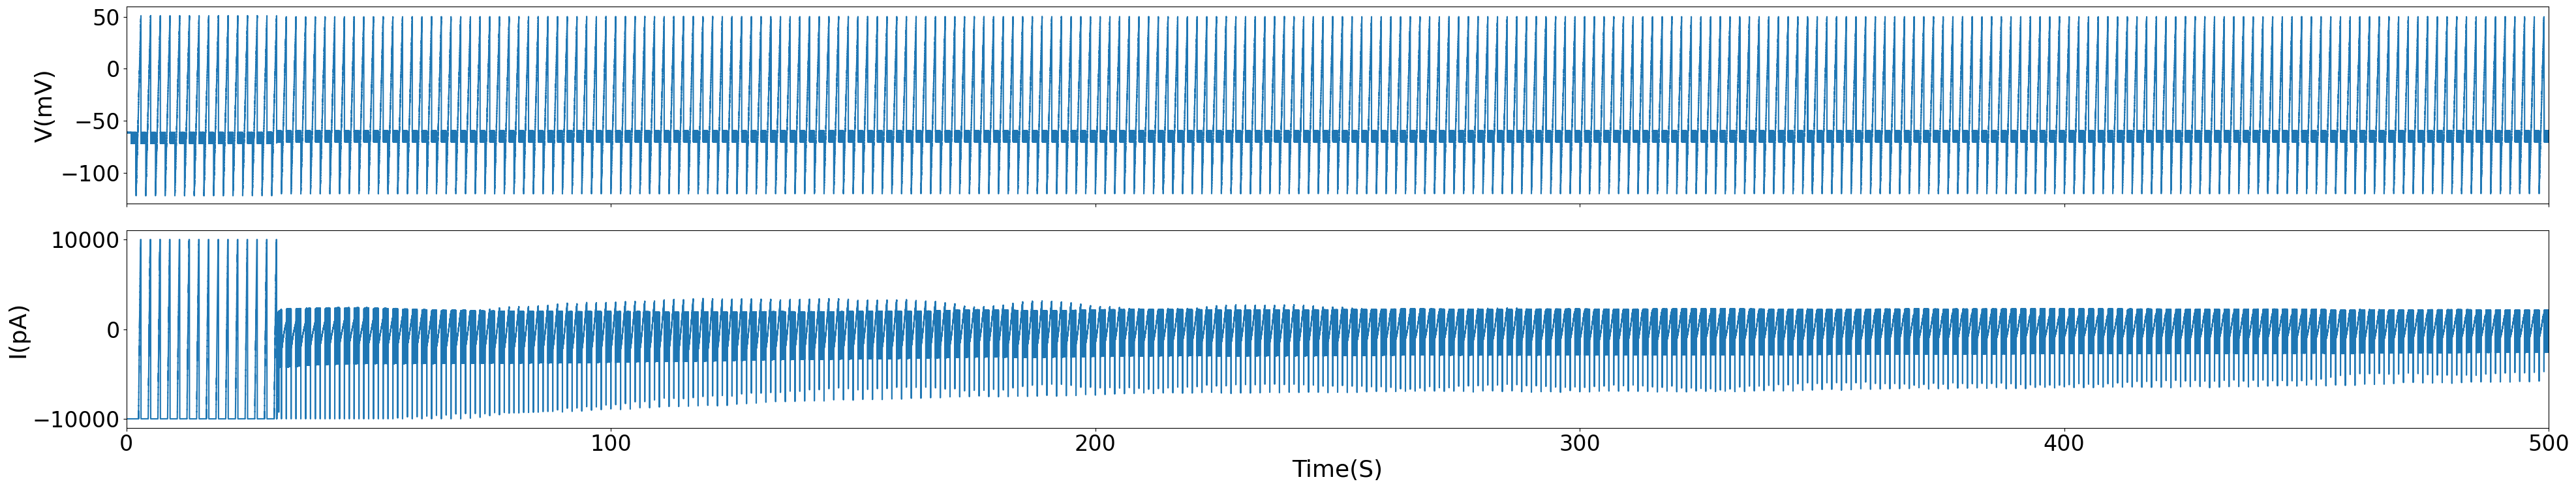

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (40,8))
t = 500
axs[0].plot(times[np.where(times<t)], V_cc['signal'][np.where(times<t)])
axs[0].set_ylim(-130,60)
axs[0].set_ylabel('V(mV)')
#axs[0].set_xlim(times.min(), times.max())
axs[0].set_xlim(0,t)
axs[1].plot(times[np.where(times<t)], I_cc['signal'][np.where(times<t)])
axs[1].set_ylabel('I(pA)')
axs[1].set_xlabel('Time(S)')
SMALL_SIZE = 24
MEDIUM_SIZE = 26
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig.tight_layout()
plt.show()

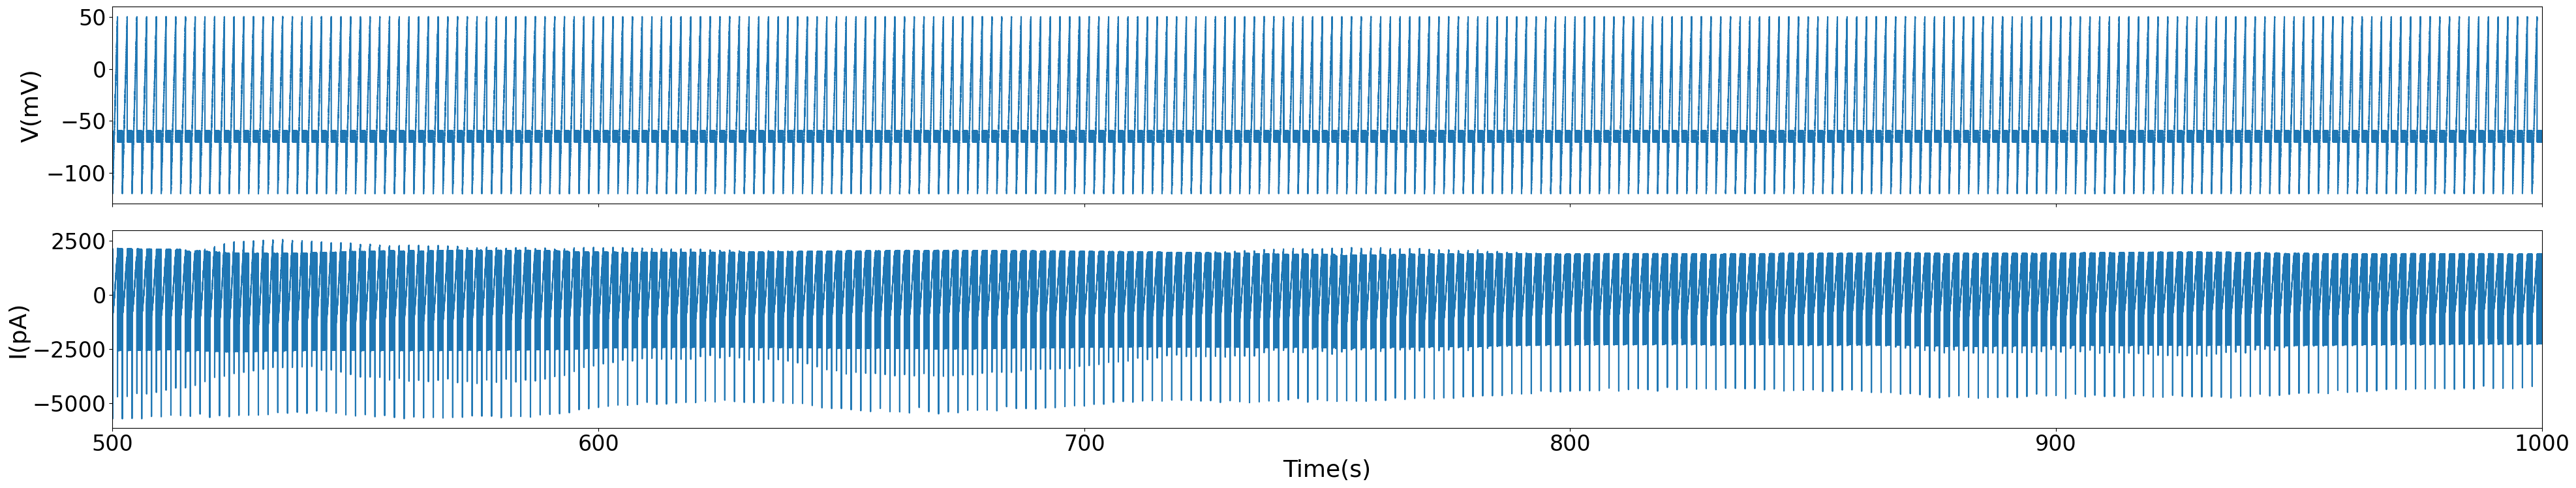

In [15]:

fig, axs = plt.subplots(2, 1, sharex=True, figsize = (40,8))
t_min = 500
t_max = 1000

axs[0].plot(times[(times>=t_min)&(times<t_max)], V_cc['signal'][(times>=t_min)&(times<t_max)])
axs[0].set_ylim(-130,60)
axs[0].set_ylabel('V(mV)')
#axs[0].set_xlim(times.min(), times.max())
axs[0].set_xlim(t_min,t_max)
axs[1].plot(times[(times>=t_min)&(times<t_max)], I_cc['signal'][(times>=t_min)&(times<t_max)])

axs[1].set_ylabel('I(pA)')
axs[1].set_xlabel('Time(s)')
SMALL_SIZE = 24
MEDIUM_SIZE = 26
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig.tight_layout()
plt.show()

In [60]:
t_b_initial = times[(V<-120)&(times>31)][0]
t_b = np.arange(t_b_initial,500,2)
Vs_b = []
Is_b = []

for t in t_b:
    V = np.squeeze(V_cc['signal'])
    I = np.squeeze(I_cc['signal'])
    Vs_b.append(V[(times>=t)&(times<t+1)])
    Is_b.append(I[(times>=t)&(times<t+1)])
    
print(Vs_b, Is_b)

MemoryError: Unable to allocate 85.1 MiB for an array with shape (89189008,) and data type bool

In [16]:
#video for breaking in
%matplotlib notebook 
from IPython import display
from matplotlib.animation import FuncAnimation
plt.ioff()

fig, ax = plt.subplots()
line, = ax.plot(Vs_b[0],Is_b[0])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Voltage (mV)',loc = 'left')
plt.ylabel('Current (pA)',loc = 'bottom')
plt.ylim([-4000,4000])


def init():
    line.set_ydata([np.nan] * len(Is_b))

def animate(i):
    line.set_ydata(Is_b[i])  # update the data
    
ani = FuncAnimation(fig, animate, init_func=init, interval=200)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()  

<IPython.core.display.Javascript object>


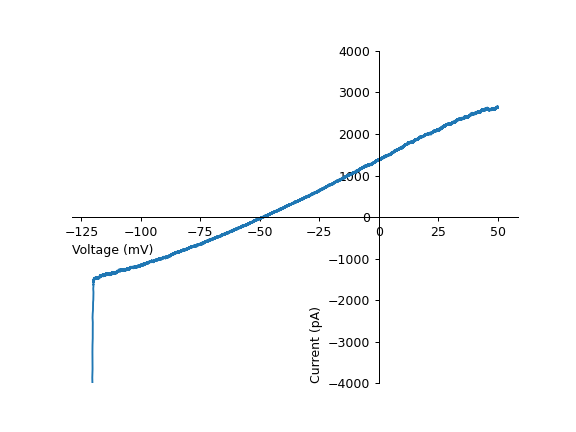

In [31]:
fig, ax = plt.subplots()
line, = ax.plot(Vs_b[0],Is_b[0])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Voltage (mV)',loc = 'left')
plt.ylabel('Current (pA)',loc = 'bottom')
plt.ylim([-4000,4000])
ani = FuncAnimation(fig, animate, init_func=init, interval=50, repeat = False, frames = 233, save_count = 233)
plt.show()

In [ ]:
t_b_initial = times[(V<-120)&(times>31)][0]
t_b = np.arange(t_b_initial,500,2)
Vs_b = []
Is_b = []

for t in t_b:
    V = np.squeeze(V_cc['signal'])
    I = np.squeeze(I_cc['signal'])
    Vs_b.append(V[(times>=t)&(times<t+1)])
    Is_b.append(I[(times>=t)&(times<t+1)])
    
print(Vs_b, Is_b)

In [26]:
t_initial = times[(V<-120)&(times>31)][0]

t_last = 2200
t_initials = np.arange(t_initial,t_last,2)

Vs = []
Is = []
for t in t_initials:
    V = np.squeeze(V_cc['signal'])
    I = np.squeeze(I_cc['signal'])
    Vs.append(V[(times>=t)&(times<t+1)])
    Is.append(I[(times>=t)&(times<t+1)])

In [27]:
len(Is)

1084

<IPython.core.display.Javascript object>


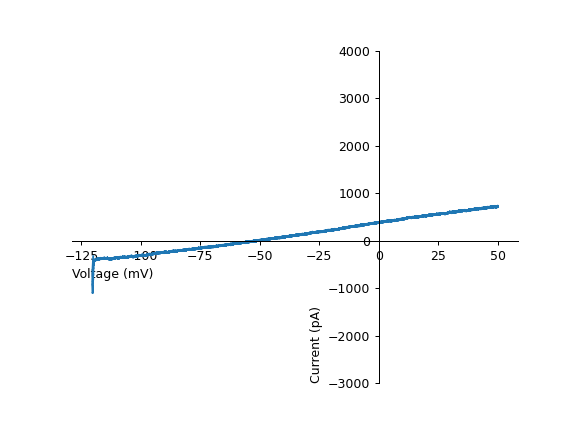

In [35]:
fig, ax = plt.subplots()
line, = ax.plot(Vs[0],Is[0])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Voltage (mV)',loc = 'left')
plt.ylabel('Current (pA)',loc = 'bottom')
plt.ylim([-3000,4000])

def init():
    line.set_ydata([np.nan] * len(Is))

def animate(i):
    line.set_ydata(Is[i])  # update the data
ani = FuncAnimation(fig, animate, init_func=init, interval=50, repeat = False, frames = 1084, save_count = 1084)
ani.save('Desktop/2nd_overall.mp4')
plt.show()

1084


<IPython.core.display.Javascript object>


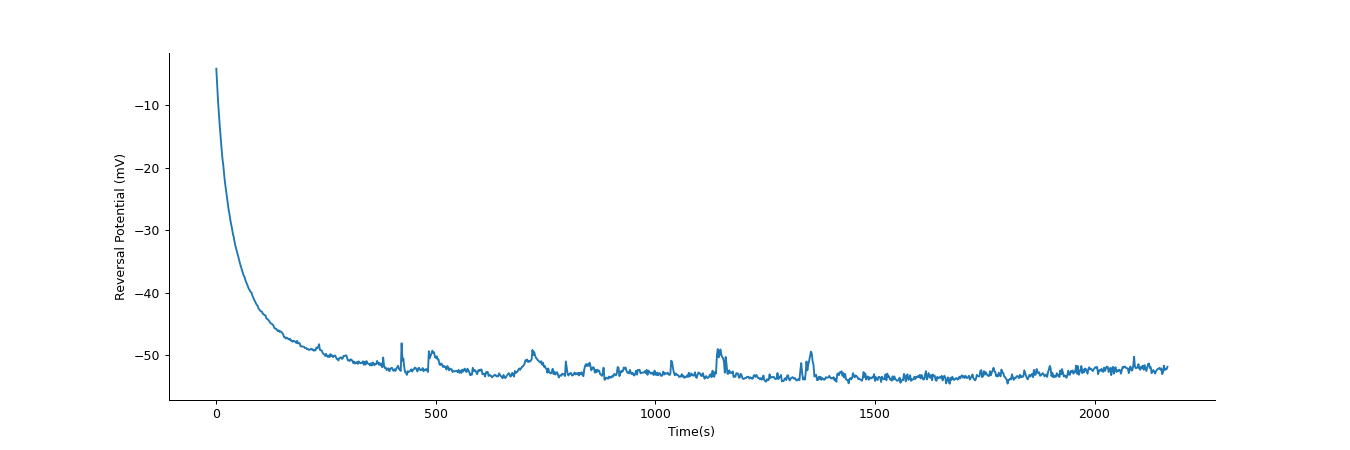

In [41]:
from sklearn import  linear_model
#using linear regression for each ramp to find the y-intercept
V_rev = []
a = 5 #this is the linear fitting threshold
for i in range(len(Vs)):
    x = Is[i][np.where((Is[i] >= -a) & (Is[i] <=a))].reshape(1, -1)
    y = Vs[i][np.where((Is[i] >= -a) & (Is[i] <=a))].reshape(1, -1)
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    V_rev.append(reg.intercept_.mean())
    
t = np.arange(0,len(V_rev)*2,2)
print(len(V_rev))
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t,V_rev)
#ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.xlabel('Time(s)')
plt.ylabel('Reversal Potential (mV)')
plt.show()

1084


<IPython.core.display.Javascript object>


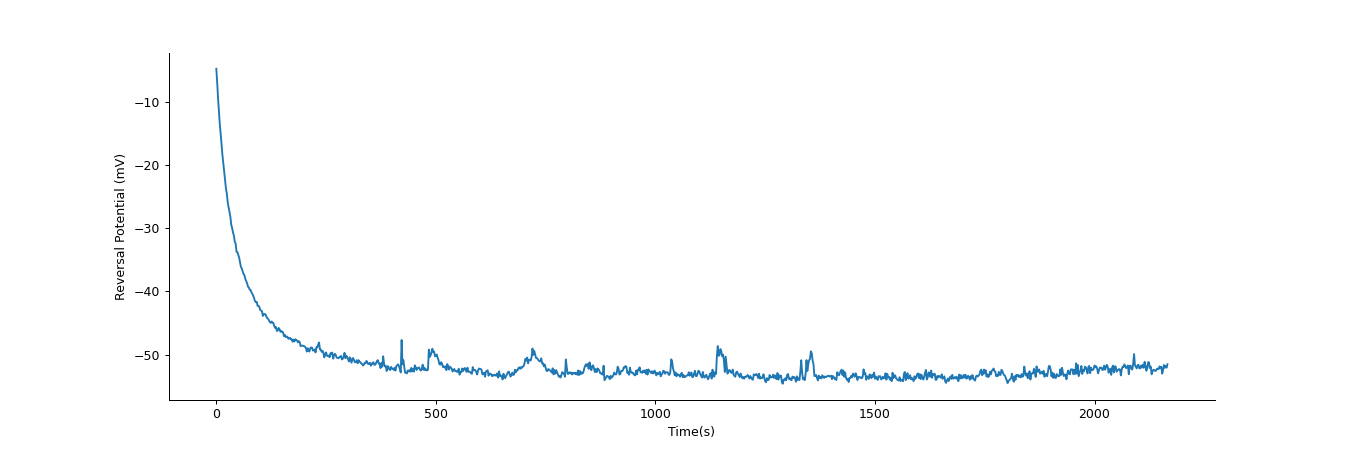

In [42]:
# this is trying to find the x-intercept for each ramp
V_rev = []
for i in range(len(Vs)):
    if len(Vs[i][Is[i] == 0]) != 0:
        V_rev.append(Vs[i][Is[i] == 0].mean())
    else:
        min_index = min(range(len(Is[i])), key=lambda j: abs(Is[i][j]-0))
        V_rev.append(Vs[i][min_index])
#V_rev

t = np.arange(0,len(V_rev)*2,2)
print(len(V_rev))
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t,V_rev)
#ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.xlabel('Time(s)')
plt.ylabel('Reversal Potential (mV)')
plt.show()

In [232]:
from scipy import optimize
import math
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C
def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = optimize.curve_fit(model_func, t, y, p0=[1,-0.5, 1],maxfev = 2000)
    A, K, C = opt_parms
    return A, K, C

5.529579162598296
5.55016407234743
6.560856168246277e-05
74.35839611394562


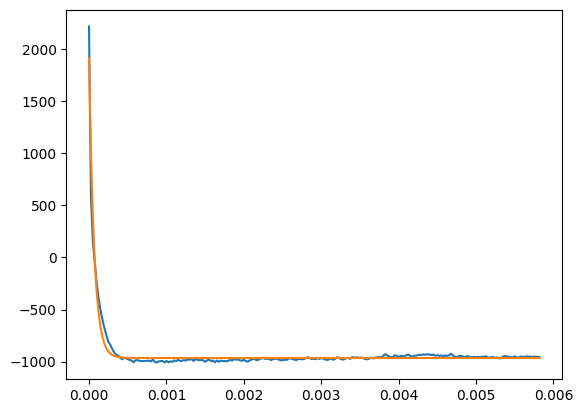

In [124]:
t = times[(times>=t_seal[0]-0.00785)&(times<t_seal[0]-0.002)]
ttest = t - t[0]
I_exp = I[(times>=t_seal[0]-0.00785)&(times<t_seal[0]-0.002)]
#plt.plot(t,I_exp)
#
# Non-linear Fit
A, K, C = fit_exp_nonlinear(ttest, I_exp)
fit_y = model_func(ttest, A, K, C)

plt.plot(ttest, I_exp)
plt.plot(ttest, fit_y)
def integrate(x, y):
    area = np.trapz(y=y, x=x)
    return area
print(integrate(ttest, np.abs(I_exp)))
print(integrate(ttest, np.abs(fit_y)))
q1 = integrate(ttest, np.abs(fit_y))
tau = 1/-K #tau is in seconds
print(tau)
q2 = Is_diff[-500] * tau #tau is in seconds, I is in pA
cm = (q1+q2)/Vs_diff[-500] #voltage is in mV, so cm is now in nF
cm = cm *1000 #now cm is in pF
Rt = Vs_diff[-500]/Is_diff[-500]*1000 #now the Rt is in Megaohm
#Ra2 - Ra * Rt + Rt * (Tau/Cm) = 0
a = 1
b = -Rt 
c = Rt*(tau/cm ) 
dis = b * b - 4 * a * c 
sqrt_val = math.sqrt(abs(dis))
Ra1 = (-b+sqrt_val)/2*a
Ra2 = (-b-sqrt_val)/2*a
print(Ra1)
#print(len(t))

In [245]:
#compute access resistance over time
#calculate acceptance resistance during breaking in
#t_seal_initial = times[(V<-10)&(times>32.86)][0]
#t_upper_initial = 33.05881
t_upper_initial = 33.06581
#t_lower_initial = t_upper_initial + 0.01
t_seal = np.arange(t_upper_initial,2200,2)

Vs_seal_upper = []
Is_seal_upper = []

Vs_seal_lower = []
Is_seal_lower = []

I_exp = []

I_ss = []
Ra = []
Cm = []
R = []
for t in t_seal:
    V = np.squeeze(V_cc['signal'])
    I = np.squeeze(I_cc['signal'])
    
    V_u = V[(times>=t-0.002)&(times<t+0.002)].mean()
    I_u = I[(times>=t-0.002)&(times<t+0.002)].mean()

    
    Vs_seal_upper.append(V_u)
    Is_seal_upper.append(I_u)
    
    V_l = V[(times>=t+0.01-0.002)&(times<t+0.012)].mean()
    I_l = I[(times>=t+0.01-0.002)&(times<t+0.012)].mean()
    
    Vs_seal_lower.append(V_l)
    Is_seal_lower.append(I_l)
    
    I_ss.append((I_u + I_l)/2)
    
    I_exp = I[(times>=t-0.0078)&(times<t-0.002)]

    t_u = times[(times>=t-0.0078)&(times<t-0.002)]
    ttest = t_u - t_u[0]
    
    # Non-linear Fit
    A, K, C = fit_exp_nonlinear(ttest, I_exp)
    fit_y = model_func(ttest, A, K, C)
    integrate_part = fit_y + np.abs(fit_y.min())
    if any(n < 0 for n in integrate_part):
        print('Warning - still have netative values here')
    q1 = integrate(ttest, integrate_part)
    q1 = q1*1e-12
    tau = 1/-K #tau is in seconds
    q2 = (I_u - I_l)*1e-12 * tau #tau is in 1/seconds, deltaI is in amps
    cm = (q1+q2)/(V_u - V_l)
    cm = cm/1e-3 #cm is now in farad
    Cm.append(cm*1e12)#now cm is in pF
    Rt = (V_u - V_l)*1e-3*1e12/(I_u - I_l)# now Rt is in ohms
    R.append(Rt*1e-6)
    #Ra2 - Ra * Rt + Rt * (Tau/Cm) = 0
    a = 1
    b = -Rt 
    c = Rt*(tau/(cm)) 

    dis = b * b - 4 * a * c 
    sqrt_val = math.sqrt(abs(dis))
    Ra1 = (-b+sqrt_val)/2*a
    Ra2 = (-b-sqrt_val)/2*a
    Ra.append(Ra1/1e6)
    
#print(Vs_seal, t_seal)

#print(Vs_seal_upper,Vs_seal_lower,Is_seal_upper,Is_seal_lower)

#Vs_diff = np.array(Vs_seal_upper) - np.array(Vs_seal_lower)
#Is_diff = np.array(Is_seal_upper) - np.array(Is_seal_lower)
#print(Vs_diff, Is_diff)
#r = np.array(Vs_diff)/np.array(Is_diff)


C:\Users\Firefly\anaconda3\envs\cancer_tutorial\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Firefly\anaconda3\envs\cancer_tutorial\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


0.0004535970707744102

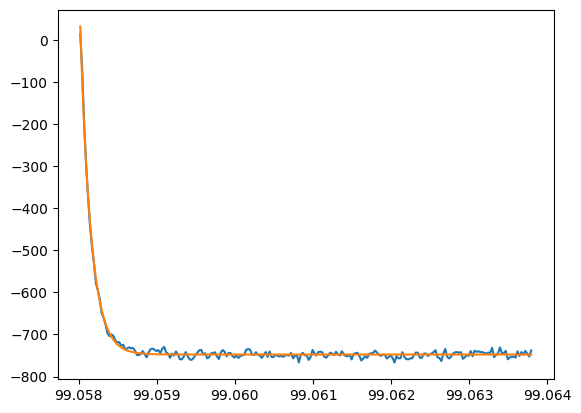

In [152]:
Vs_diff = np.array(Vs_seal_upper) - np.array(Vs_seal_lower)
Is_diff = np.array(Is_seal_upper) - np.array(Is_seal_lower)

Rt = np.array(Vs_diff)/np.array(Is_diff)
Rt*1000

array([52.488014, 58.68994 , 63.646652, 60.457355, 58.15578 , 61.321968,
       53.41538 , 66.240265, 57.614223, 57.720985, 45.1397  , 55.17782 ,
       51.11765 , 51.100883, 45.815662, 42.48588 , 42.94809 , 42.734184,
       41.395374, 37.875965, 39.29665 , 38.285767, 36.45244 , 36.90585 ,
       34.111782, 36.007786, 37.37866 , 35.121727, 32.68343 , 31.792606,
       33.1681  , 32.8865  , 30.970211, 32.12434 ], dtype=float32)

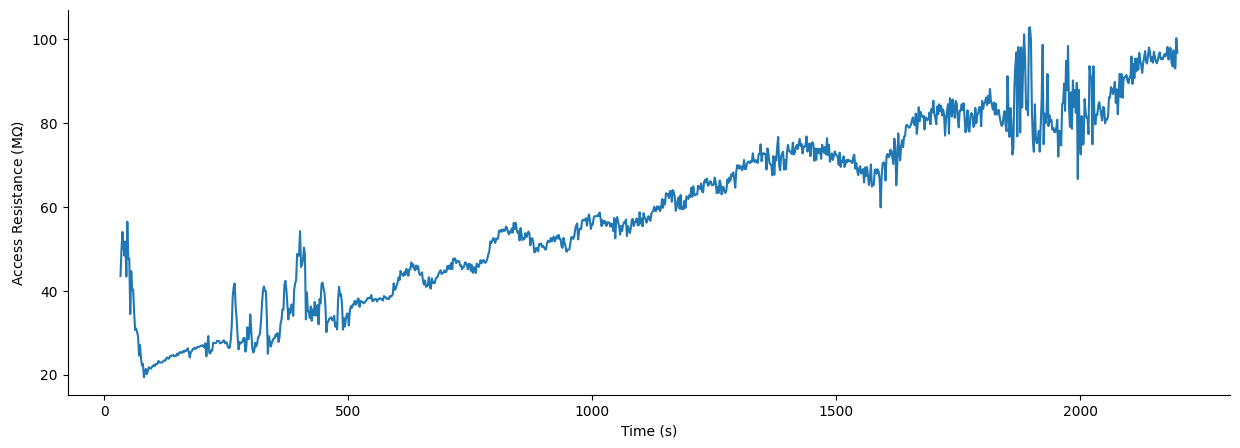

In [246]:
r_accept = Ra
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t_seal,r_accept)
#ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
#plt.ylim([-200,200])
# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Time (s)')
plt.ylabel('Access Resistance (M$\Omega$)')
plt.show()

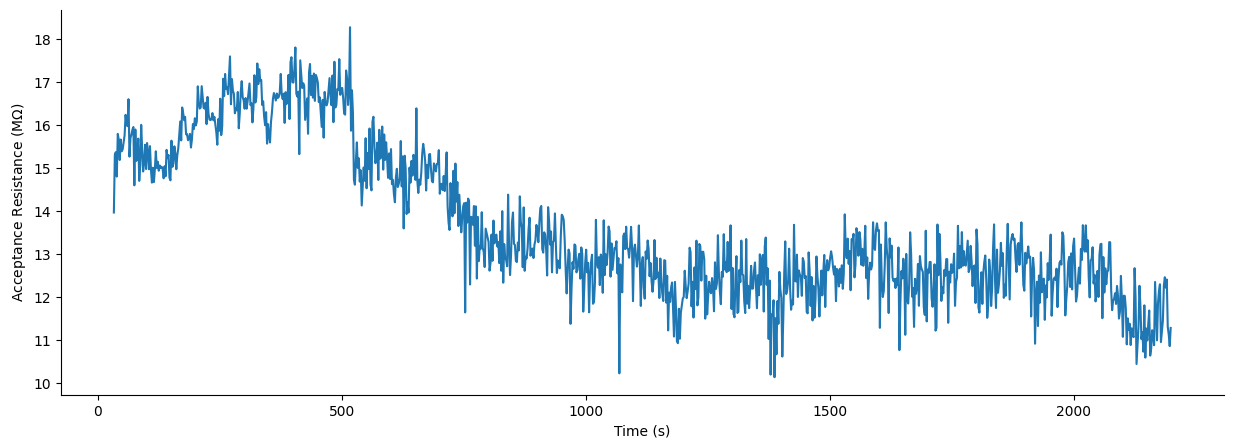

In [247]:
r_accept= Cm
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t_seal,r_accept)
#ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
#plt.ylim([-200,200])
# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Time (s)')
plt.ylabel('Acceptance Resistance (M$\Omega$)')
plt.show()